## 1. Importaciones

## 1.1 Librerías y parámetros

In [ ]:
!pip install --upgrade torch torchvision

In [ ]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import cv2

In [ ]:
cuda = True
train_batch_size = 32
test_batch_size = 124
best_loss = float("inf")
best_epoch = -1
dataset_path = './cifar10'
gsync_save = True

In [ ]:

try:
    import torch
except ModuleNotFoundError:
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.1-{platform}-linux_x86_64.whl
    import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


try:
    import torchvision
except ModuleNotFoundError:
    !pip install -q torchvision

from torchvision import datasets, transforms


if gsync_save:
    try:
        import utils
    except ModuleNotFoundError:
        !wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
        import utils

## 1.2 Arquitectura de AllConvNet

In [ ]:
class AllConvNet(nn.Module):
    def __init__(self, input_size, n_classes=10, **kwargs):
        super(AllConvNet, self).__init__()
        self.conv1 = nn.Conv2d(input_size, 96, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(96, 96, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(96)
        self.conv3 = nn.Conv2d(96, 96, 3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(96, 192, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(192)
        self.conv5 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(192)
        self.conv6 = nn.Conv2d(192, 192, 3, padding=1, stride=2)
        self.bn6 = nn.BatchNorm2d(192)
        self.conv7 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(192)
        self.conv8 = nn.Conv2d(192, 192, 1)
        self.bn8 = nn.BatchNorm2d(192)

        self.class_conv = nn.Conv2d(192, n_classes, 1)

    def forward(self, x):
        x_drop = F.dropout(x, .2)
        conv1_out = F.relu(self.bn1(self.conv1(x_drop)))
        conv2_out = F.relu(self.bn2(self.conv2(conv1_out)))
        conv3_out = F.relu(self.bn3(self.conv3(conv2_out)))
        conv3_out_drop = F.dropout(conv3_out, .5)
        conv4_out = F.relu(self.bn4(self.conv4(conv3_out_drop)))
        conv5_out = F.relu(self.bn5(self.conv5(conv4_out)))
        conv6_out = F.relu(self.bn6(self.conv6(conv5_out)))
        conv6_out_drop = F.dropout(conv6_out, .5)
        conv7_out = F.relu(self.bn7(self.conv7(conv6_out_drop)))
        conv8_out = F.relu(self.bn8(self.conv8(conv7_out)))

        class_out = F.relu(self.class_conv(conv8_out))
        pool_out = F.adaptive_avg_pool2d(class_out, 1)
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        return pool_out

## 2. Transformacion y carga de datos

In [ ]:
# Damos acceso a google drive para guardar modelos

drive.mount('/content/gdrive');

Mounted at /content/gdrive


In [ ]:
class NormalizeNegativeImages(object):

    def __call__(self, item):
        min_value_pixel = torch.min(item)
        if min_value_pixel < 0:
            item -= min_value_pixel
            item /= torch.max(item)
        return item

In [ ]:
# Semilla para estandarizar resultados
torch.manual_seed(2320)

cuda = cuda and torch.cuda.is_available()
trainset = datasets.CIFAR10(root=dataset_path, train=True, download=True)
train_mean = trainset.data.mean(axis=(0, 1, 2)) / 255
train_std = trainset.data.std(axis=(0, 1, 2)) / 255

# Data normal (32x32)

transform_train = transforms.Compose([
     transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(train_mean, train_std),
     NormalizeNegativeImages()
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages()
])

#  transformaciones a 8x8 y de vuelta a 32x32 por bilineal

transform_train8x8 = transforms.Compose([
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages()
])

transform_test8x8 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages(),
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
])

# Crearemos transformaciones sin randomizar nada para la resta de imágenes.

transform_train_no_random = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(train_mean, train_std),
     NormalizeNegativeImages()
])

transform_train8x8_no_random = transforms.Compose([
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages()
])

100%|██████████| 170498071/170498071 [00:05<00:00, 28951480.78it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# Data normal

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train),
    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test),
    batch_size=test_batch_size, shuffle=True, **kwargs)


# Data de entrenamiento blurreada

train_loader_blur = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train8x8),
    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader_blur = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test8x8),
    batch_size=test_batch_size, shuffle=True, **kwargs)

# Sin random

train_loader_no_random = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train_no_random),
    batch_size=train_batch_size, shuffle=False, **kwargs)

train_loader_blur_no_random = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train8x8_no_random),
    batch_size=train_batch_size, shuffle=False, **kwargs)

test_loader_no_random = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test),
    batch_size=test_batch_size, shuffle=False, **kwargs)

test_loader_blur_no_random = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test8x8),
    batch_size=test_batch_size, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class SubtractedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.transform = transforms.ToTensor()
        assert len(self.dataset1) == len(self.dataset2), "Datasets must have the same length"

    def __getitem__(self, index):
        item1 = self.dataset1[index]
        item2 = self.dataset2[index]
        subtracted_image = item1[0] - item2[0]
        min_value_pixel = torch.min(item1[0] - item2[0])
        if min_value_pixel < 0:
          subtracted_image -= min_value_pixel
          subtracted_image /= torch.max(subtracted_image)
        return subtracted_image, item1[1]

    def __len__(self):
        return len(self.dataset1)

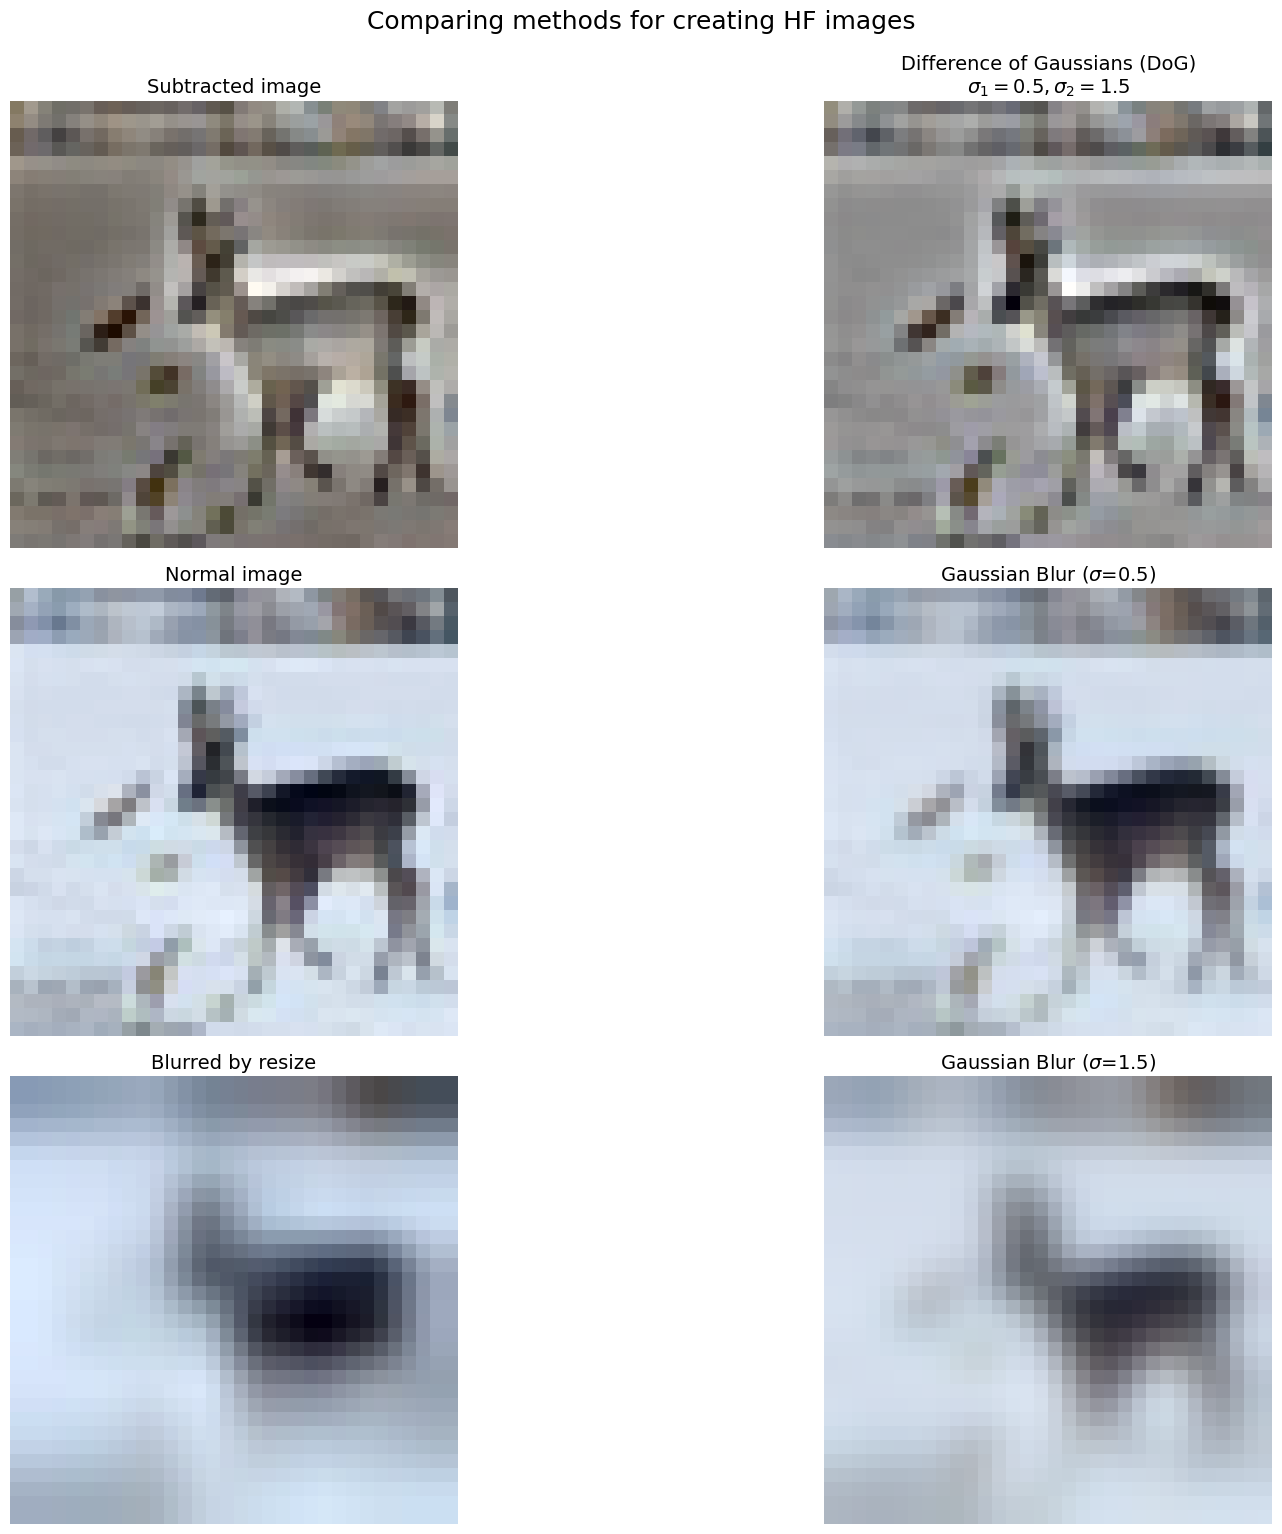

In [ ]:
subtracted_dataset = SubtractedDataset(train_loader_no_random.dataset, train_loader_blur_no_random.dataset)
subtracted_loader = torch.utils.data.DataLoader(subtracted_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
subtracted_loader_no_random = torch.utils.data.DataLoader(subtracted_dataset, batch_size=train_batch_size, shuffle=False, **kwargs)

subtracted_testset = SubtractedDataset(test_loader_no_random.dataset, test_loader_blur_no_random.dataset)
substracted_testloader = torch.utils.data.DataLoader(subtracted_testset, batch_size=train_batch_size, shuffle=True, **kwargs)

fig, ax = plt.subplots(3, 2, figsize=(20, 15))
loaders = [subtracted_loader_no_random, train_loader_no_random, train_loader_blur_no_random]
label = ['Subtracted image', 'Normal image', 'Blurred by resize']

for ax_index, loader in enumerate(loaders):
    for batch_data, batch_labels in loader:
        first_image = batch_data[20].permute(1, 2, 0).numpy()
        ax[ax_index, 0].imshow(first_image)
        ax[ax_index, 0].set_title(label[ax_index], fontsize=14)
        ax[ax_index, 0].axis('off')
        break

for batch_data, batch_labels in train_loader_no_random:
    first_image = batch_data[20].permute(1, 2, 0).numpy()
    image_float32 = np.float32(first_image)
    sigma1 = .5
    sigma2 = 1.5
    gaussian1 = cv2.GaussianBlur(image_float32, (0, 0), sigmaX=sigma1)
    gaussian2 = cv2.GaussianBlur(image_float32, (0, 0), sigmaX=sigma2)
    dog = gaussian1 - gaussian2
    dog_normalized = (dog - np.min(dog)) / (np.max(dog) - np.min(dog)) * 255
    dog_normalized = dog_normalized.astype(np.uint8)

    ax[0, 1].imshow(dog_normalized, cmap='viridis')
    ax[0, 1].set_title('Difference of Gaussians (DoG)\n$\sigma_1={}, \sigma_2={}$'.format(sigma1, sigma2), fontsize=14)
    ax[0, 1].axis('off')

    ax[1, 1].imshow(gaussian1, cmap='viridis')
    ax[1, 1].set_title('Gaussian Blur ($\sigma$={})'.format(sigma1), fontsize=14)
    ax[1, 1].axis('off')

    ax[2, 1].imshow(gaussian2, cmap='viridis')
    ax[2, 1].set_title('Gaussian Blur ($\sigma$={})'.format(sigma2), fontsize=14)
    ax[2, 1].axis('off')
    break

plt.subplots_adjust(top=0.9)
plt.tight_layout()

fig.suptitle('Comparing methods for creating HF images', fontsize=18, y=1.02)

std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos'
path = std_text + '/Graficos/Blur_HF_and_Normal_Images_Comparison.png'

# plt.savefig(path, bbox_inches='tight')

## 3. definición de funciones de entrenamiento

### 3.1. Funciones auxiliares

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
# Se definen funciones auxiliares

def initialize_model():

    '''
    Initialize a simple AllConvNet(3) and returns the model and all the
    needed information to train it.
    '''

    global cuda
    global criterion

    model = AllConvNet(3)

    if cuda:
        model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[200, 250, 300],
                gamma=0.1)

    return model, optimizer, criterion, scheduler


def pretty_print(text: str, char='*'):

    '''
    Prints in a prettier way with more space. You can change the asterisks
    if something else is prefered.
    '''

    n_char = len(text)
    print(
    f'''
    {char * n_char}
    {text}
    {char * n_char}
    ''')


def load_pretrained_model(drive_path=None):

    '''
    Reads the google drive path and load the model into an AllConvNet(3). It loads
    the optimizer as well. If no path is given, the function instanciates an
    AllConvNet(3) and the necessary classes for the training and testing.
    '''

    global cuda
    global criterion

    model = AllConvNet(3)

    if cuda:
      model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    if drive_path is None:
      model_data = {
      'pretrained_epochs': 0,
      'model_state_dict': -1,
      'optimizer_state_dict': -1,
      'final_accuracy': 0,
      'training_data_dict': {},
      'test_data_dict': {}}

    else:
      model_data = torch.load(drive_path)
      model_state_dict = model_data['model_state_dict']
      opt_state_dict = model_data['optimizer_state_dict']
      model.load_state_dict(model_state_dict)
      optimizer.load_state_dict(opt_state_dict)

    scheduler = optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[200, 250, 300], gamma=0.1)

    return_dict = {'model': model,
                   'model_data': model_data,
                   'optimizer': optimizer,
                   'scheduler': scheduler}

    return return_dict


def save_training_data(save_dict: dict, acc: int, current_epoch: int,
                       total_epochs: int, save_every=10):

    '''
    If the current epoch is a multiple of the a determined number, or is the last
    epoch, the function takes an existing dictionary containing the epochs as
    keys and the accuracy as value, and adds the acc of the current epoch.
    '''

    if current_epoch % save_every == 0 or current_epoch == total_epochs:
      round_acc = round(acc.item(), 2)
      save_dict[f'{current_epoch}'] = round_acc
      pretty_print(f'Data saved: ({current_epoch}, {round_acc})', char='-')
    return save_dict


def save_model(pretrained_epochs, model_state_dict, optimizer_state_dict,
               final_accuracy, training_data_dict, checkpt_path):

    '''
    Saves the AllConvNet model with all the imporatant information in the given
    drive path.
    '''

    checkpoint = {
      'pretrained_epochs': pretrained_epochs,
      'model_state_dict': model_state_dict,
      'optimizer_state_dict': optimizer_state_dict,
      'final_accuracy': round(final_accuracy, 2),
      'training_data_dict': training_data_dict}

    torch.save(checkpoint, checkpt_path)


def save_plot(path: str, training_data: dict, altered_testing_data: dict,
              altered_begin: int, blur=False):

    '''
    Generates a graph of epochs vs accuracies by using the keys and values stored
    in a dictionary. Then, the plot is save into the given drive path.
    '''

    epocas = list(training_data.keys())
    accuracies = list(training_data.values())

    title_text = f'Epochs vs Accuracies (Trained with HF images since epoch {altered_begin} for 40 epochs)'
    train_stuff = 'High Frecuency'

    if blur:
        title_text = f'Epochs vs Accuracies (Trained with blurred images since epoch {altered_begin} for 40 epochs)'
        train_stuff = 'Blurred'

    ax = plt.figure(figsize=(12,6))
    plt.plot(epocas, accuracies, label=f'Trained with {train_stuff} Images')
    plt.grid()
    plt.title(title_text)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracies')

    last_acc, last_ep = accuracies[-1], epocas[-1]
    text_upper_left = f'Last {train_stuff} epoch: {last_ep}\nLast {train_stuff} acc: {last_acc:.2f}'
    plt.text(0.02, 0.79, text_upper_left, transform=plt.gca().transAxes,
            bbox=dict(facecolor='lightgray', edgecolor='lightgray',
                      boxstyle='round,pad=0.5', alpha=0.5))

    # Añadir los cuadros de texto sobre épocas múltiplos de 40.

    for ep, acc in zip(epocas, accuracies):
        if int(ep) % 40 == 0:
            text = f'Epoch: {ep}\nAcc: {acc:.2f}'
            plt.annotate(text, (ep, acc), textcoords="offset points", xytext=(0,-8),
                         ha='center', va='bottom', bbox=dict(facecolor='lightgray',
                         edgecolor='lightgray', boxstyle='round,pad=0.5', alpha=0.5))

    # Plotear el modelo entrenado con imágenes normales.

    std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos'
    normal_image_training_path = std_text + '/allconv_noblur_checkpts/checkpoint_epoch_360.pt'
    normal_images_data = load_pretrained_model(normal_image_training_path)
    model_data_normal = normal_images_data['model_data']
    train_data_normal = model_data_normal['training_data_dict']

    epochs_normal = list(train_data_normal.keys())
    accs_normal = list(train_data_normal.values())
    plot_length = len(epocas)
    plt.plot(epochs_normal[:plot_length], accs_normal[:plot_length],
              color='lightgreen', linestyle='--',
              label='Normal images training')

    # Plotear accuaracy del modelo para clasificar el altered loader

    altered_epochs_test = list(altered_testing_data.keys())
    altered_epochs_acc = list(altered_testing_data.values())
    plt.plot(altered_epochs_test, altered_epochs_acc,
             label=f'Test with {train_stuff} Images')


    plt.scatter(epocas, accuracies, color='orange')
    plt.legend()
    plt.tight_layout()
    plt.savefig(path)

In [ ]:
def train(epoch: int, loader: torch.utils.data.DataLoader,
          model: AllConvNet, optimizer):

    global criterion
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
          print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))


def test(epoch: int, best_loss: int, best_epoch: int,
         testloader: torch.utils.data.DataLoader, model: AllConvNet):

    global criterion
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
        acc = 100*correct/len(test_loader.dataset)

    test_loss /= len(test_loader.dataset)
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {} ({:.0f}%)\n'.format(
            test_loss, acc, 100. * correct /
            len(test_loader.dataset)))

    if test_loss < best_loss:
        best_epoch = epoch
        best_loss = test_loss

    return best_loss, best_epoch, acc

### 3.2 definición de modelo

In [ ]:
def begin_model_easy(normal_loader: torch.utils.data.DataLoader,
                     altered_loader: torch.utils.data.DataLoader,
                     normal_test: torch.utils.data.DataLoader,
                     altered_test: torch.utils.data.DataLoader,
                     normal_init=0, altered_epochs=40, after_altered=160,
                     model_path=None):

  '''
  Trains the model by using the two given loaders (altered and normal), in the
  periods indicated. If no model path is given, then an AllConvNet(3) is
  instanciated. Parameters related to the number of epochs to train with each
  dataset are set to run as they are in Achille et al. experiment.
  '''

  criterion = nn.CrossEntropyLoss()
  loader_type = torch.utils.data.dataloader.DataLoader
  best_loss = float("inf")
  best_epoch = -1
  num_parameters_not_ok = (normal_init < 0 or altered_epochs < 0 or after_altered < 0)
  loaders_not_ok = (altered_loader is loader_type or normal_loader is loader_type)

  if num_parameters_not_ok or loaders_not_ok:
    raise Exception("There are Inconsistencies in the parameters")

  else:
    packed_data = load_pretrained_model(drive_path=model_path)
    model = packed_data['model']
    model_data = packed_data['model_data']
    scheduler = packed_data['scheduler']
    optimizer = packed_data['optimizer']
    training_data_dict = model_data['training_data_dict']
    test_data_dict = model_data.get('test_data_dict', {})
    pretrained_epochs = model_data['pretrained_epochs']
    orig_acc = model_data['final_accuracy']
    total_epochs = pretrained_epochs + normal_init + altered_epochs + after_altered
    training_begins_from = pretrained_epochs

    if training_begins_from == 0:
      training_begins_from = -1

    if normal_init == 0:

      pretty_print(f'Begin training with altered images')
      pretty_print(f"Accuracy before training: {orig_acc}", ' ')
      for epoch in range(training_begins_from + 1,
                         pretrained_epochs + altered_epochs + 1):
        scheduler.step()
        train(epoch, altered_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs)

      pretty_print('Altered image training finished. Training with normal images')
      for epoch in range(pretrained_epochs + altered_epochs + 1,
                         pretrained_epochs + altered_epochs + after_altered + 1):
        scheduler.step()
        train(epoch, normal_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs)

    elif normal_init != 0:

      pretty_print("Begin training with normal images")
      pretty_print(f"Accuracy before training: {orig_acc}", ' ')

      for epoch in range(training_begins_from + 1,
                         pretrained_epochs + normal_init + 1):
        scheduler.step()
        train(epoch, normal_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs)

      pretty_print("Begin training with altered images")

      for epoch in range(pretrained_epochs + normal_init + 1,
                         pretrained_epochs + normal_init + altered_epochs + 1):
        scheduler.step()
        train(epoch, altered_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs)

      pretty_print('Altered image training finished. Training with normal images')

      for epoch in range(pretrained_epochs + normal_init + altered_epochs + 1,
                         total_epochs + 1):
        scheduler.step()
        train(epoch, normal_loader, model, optimizer)
        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)
        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)
        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs)

  pretty_print(f'final accuracy: {acc.item()}')

  dict_return = {'model': model,
                 'optimizer': optimizer,
                 'final_accuracy': round(acc.item(), 2),
                 'training_data_dict': training_data_dict,
                 'test_data_dict': test_data_dict,
                 'model_data': model_data}

  return dict_return

## 4. Entrenar modelo

### 4.1. Modelo sin preentrenar (directamente entramos a 40 HF)

In [ ]:
# Entrenamos modelo que empieza con 40 épocas de frecuencia alta y sigue con 120 normales
std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos'

info_dict = begin_model_easy(normal_loader=train_loader,
                             altered_loader=subtracted_loader)

model_data = info_dict['model_data']
model = info_dict['model']
optimizer = info_dict['optimizer']
training_data_dict = info_dict['training_data_dict']

checkpoint_save_path = std_text + f"/40epochs_HF_checkpts/40HF_from_0.pt"

save_model(pretrained_epochs=model_data['pretrained_epochs'],
           model_state_dict=model.state_dict(),
           optimizer_state_dict=optimizer.state_dict(),
           final_accuracy=round(model_data['final_accuracy'], 2),
           training_data_dict=training_data_dict,
           checkpt_path=checkpoint_save_path)


    **********************************
    Begin training with altered images
    **********************************
    

                                  
    Accuracy before HF training: 0
                                  
    


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train epoch: 0 [0/50000 (0%)]	Loss: 2.306393
Train epoch: 0 [3200/50000 (6%)]	Loss: 2.297748
Train epoch: 0 [6400/50000 (13%)]	Loss: 2.303003
Train epoch: 0 [9600/50000 (19%)]	Loss: 2.301045
Train epoch: 0 [12800/50000 (26%)]	Loss: 2.305574
Train epoch: 0 [16000/50000 (32%)]	Loss: 2.304615
Train epoch: 0 [19200/50000 (38%)]	Loss: 2.302826
Train epoch: 0 [22400/50000 (45%)]	Loss: 2.298939
Train epoch: 0 [25600/50000 (51%)]	Loss: 2.299357
Train epoch: 0 [28800/50000 (58%)]	Loss: 2.299984
Train epoch: 0 [32000/50000 (64%)]	Loss: 2.302306
Train epoch: 0 [35200/50000 (70%)]	Loss: 2.299388
Train epoch: 0 [38400/50000 (77%)]	Loss: 2.305692
Train epoch: 0 [41600/50000 (83%)]	Loss: 2.305147
Train epoch: 0 [44800/50000 (90%)]	Loss: 2.301142
Train epoch: 0 [48000/50000 (96%)]	Loss: 2.304099

Test set: Average loss: 0.0187, Accuracy: 10.010000228881836 (10%)


    ----------------------
    Data saved: (0, 10.01)
    ----------------------
    
Train epoch: 1 [0/50000 (0%)]	Loss: 2.301453
Train ep

TypeError: save_model() got an unexpected keyword argument 'began_blur_epoch'

{'0': 10.0, '10': 14.489999771118164, '20': 22.760000228881836, '30': 37.099998474121094, '40': 43.0, '50': 50.56999969482422, '60': 54.81999969482422, '70': 59.7599983215332, '80': 62.65999984741211, '90': 67.77999877929688, '100': 70.45999908447266, '110': 71.73999786376953, '120': 73.69000244140625, '130': 75.06999969482422, '140': 74.83000183105469, '150': 76.13999938964844, '160': 77.08000183105469, '170': 77.30000305175781, '180': 78.05999755859375, '190': 78.73999786376953, '200': 81.23999786376953, '210': 81.27999877929688, '220': 81.02999877929688, '230': 80.5199966430664, '240': 80.93000030517578, '250': 80.9000015258789, '260': 81.02999877929688, '270': 81.29000091552734, '280': 81.47000122070312}


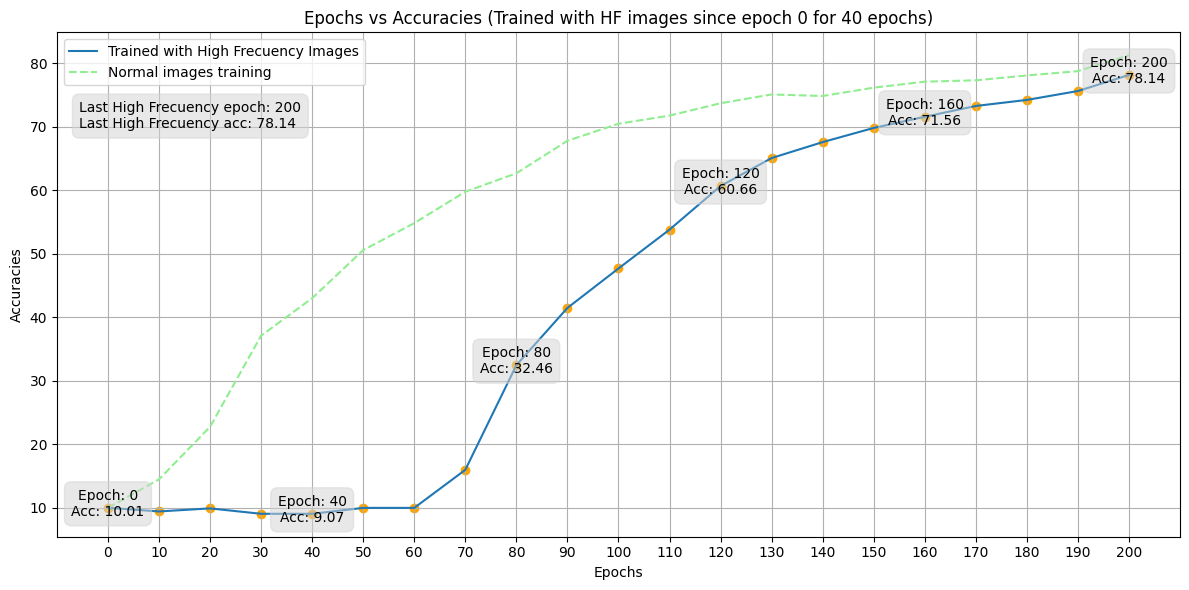

In [ ]:
# EJECUTAR DESPUES. Tener listo las 360 epocas normales

save_model(pretrained_epochs=model_data['pretrained_epochs'],
           model_state_dict=model.state_dict(),
           optimizer_state_dict=optimizer.state_dict(),
           final_accuracy=round(model_data['final_accuracy'], 2),
           training_data_dict=training_data_dict,
           checkpt_path=checkpoint_save_path)

plot_path = std_text + f"/Graficos/HF training graphs/HF_training_from_0"
save_plot(plot_path, training_data_dict, '0', blur=False)

### 4.2 Entrenar modelos preentrenados de a uno (modificar según que modelo se quiere continuar entrenando)

In [ ]:
std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos'
model_path = std_text + f'/allconv_noblur_checkpts/checkpoint_epoch_80.pt'
data_pack = begin_model_easy(normal_loader=train_loader,
                     altered_loader=train_loader_blur,
                     normal_init=0, altered_epochs=40, after_altered=160,
                     model_path=model_path)

model_data = data_pack['model_data']
model = data_pack['model']
final_acc = data_pack['final_accuracy']
optimizer = data_pack['optimizer']
training_data_dict = model_data['training_data_dict']

checkpoint_save_path = std_text + f'/40epochs_Blur_checkpts/40HF_from_80.pt'

save_model(began_blur_epoch=model_data['pretrained_epochs'],
             model_state_dict=model.state_dict(),
             optimizer_state_dict=optimizer.state_dict(),
             final_accuracy=round(final_acc, 2),
             training_data_dict=training_data_dict,
             checkpt_path=checkpoint_save_path)

# Save the plot in our drive
plot_path = std_text + f"/Graficos/Blur training graphs/Blur_training_from_80.png"
save_plot(plot_path, training_data_dict, '80', blur=False)

In [ ]:
import time

start_time = time.time()

save_model(pretrained_epochs=model_data['pretrained_epochs'],
             model_state_dict=model.state_dict(),
             optimizer_state_dict=optimizer.state_dict(),
             final_accuracy=round(model_data['final_accuracy'], 2),
             training_data_dict=training_data_dict,
             checkpt_path=checkpoint_save_path)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed Time: {elapsed_time} seconds")

Elapsed Time: 0.06356287002563477 seconds
